In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:97% !important; }</style>"))

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [3]:
import pandas as pd
pd.set_option('display.max_rows', 500)
import numpy as np
np.set_printoptions(suppress=True) #no scientific notation
from scipy.stats import chi2_contingency
from scipy.stats import norm

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import mpld3
mpld3.enable_notebook()

In [4]:
df = pd.read_csv(r"Geo Modified Dataset - 80 cells - width==0.1 .csv", index_col=(0,1))

race_set = set(['ASIAN', 'BLACK', 'HISPANIC', 'NATIVE AMERICAN', 'OTHER', 'WHITE'])
race_set_w_out_NA = set(['ASIAN', 'BLACK', 'HISPANIC', 'OTHER', 'WHITE'])

# Define Necessary Functions

In [5]:
# CONDTIONAL_SPEED_CUTOFF = 15
# #note that this cutoff is INCLUSIVE

## Create a dataframe of raw stop count

e.g. raw_count_df['ASIAN'][10] = $\#\, asian \, stops\, at\, 10\, mph\,$

In [6]:
def generate_raw_count_df(dataframe, a, b):
    count_between_a_b_mph_intermediate_dict = {race:{x:0 for x in list(range(a, b+1))} for race in race_set}
    race_total_between_a_b_mph = {race:0 for race in race_set}

    #raw count of speeds 
    for x in list(zip(dataframe['Speed Over Posted Limit'], dataframe['Race'])):
        if a <= x[0] <= b:
            count_between_a_b_mph_intermediate_dict[x[1]][x[0]] += 1
            race_total_between_a_b_mph[x[1]] += 1
            
    return pd.DataFrame(count_between_a_b_mph_intermediate_dict)

## Create a dataframe of percentage stop count

e.g. pct_stop_df['ASIAN'][10] = $\frac{asian \, stops\, at\, 10\, mph\,}{\,all\, asian\, stops}$

In [7]:
def create_speed_pct_PDF(dataframe, a, b):
    """       
    a = min speed
    b = max speed
    
    returns pd dataframe of all races' speeds percentages at a certain speed
    
    note: the range is inclusive
    """
    count_between_a_b_mph_intermediate_dict = generate_raw_count_df(df, a, b)
    
    race_total_between_a_b_mph = {race: count_between_a_b_mph_intermediate_dict[race].sum() for race in race_set}
    
    percent_between_a_b_mph_df = pd.DataFrame({race: 100 * count_between_a_b_mph_intermediate_dict[race]/count_between_a_b_mph_intermediate_dict[race].sum() for race in race_set})
    
    return percent_between_a_b_mph_df

## ~~Return % leq a specific speed ~~(No longer needed)

In [8]:
# def pct_leq_n_mph(speeding_percentages_list, n):
    
#     """
#     INCLUSIVE range
    
#     n = specific speed
#     """
    
#     return sum([mph for i, mph in enumerate(speeding_percentages_list) if i <= n]) / sum([mph for mph in speeding_percentages_list]) #make it "i+a" if want a range starting at "a"

## Returns a dataframe with df[race][x] = % $\leq $ speed *x*

In [9]:
def generate_pct_CDF(speeding_percentages_df):
    
    return speeding_percentages_df.cumsum()

## Adds columns of differences between columns

In [13]:
def create_difference_between_races(speed_CDF):
    already_done = []

    for race in race_set_w_out_NA:
        for race2 in race_set_w_out_NA:
            if race != race2:
                if sorted([race, race2]) not in already_done:
                    
                    speed_CDF[f"{race} - {race2}"] = abs(speed_CDF[race] - speed_CDF[race2])
                    
                    already_done.append(sorted([race, race2]))


# Z-test for different distributions/means

## Function for z_test

In [16]:
def z_statistic(pct_CDF_df, raw_count_CDF_df, race1, race2, speed): #meant to be applied to speed_pct_CDF
    
    p1 = pct_CDF_df[race1][speed]/100
    p2 = pct_CDF_df[race2][speed]/100
    
    n1 = raw_count_CDF_df[race1][speed]
    n2 = raw_count_CDF_df[race2][speed]
    
    numerator = p1 - p2
    
    denominator = np.sqrt( (p1 * (1-p1))/n1 + (p2 * (1-p2))/n2 )
    
    return numerator / denominator

In [17]:
def create_z_stat_df(pct_CDF_df, raw_count_CDF_df, CONDTIONAL_SPEED_CUTOFF):#, CONFIDENCE):
    
    local_z_stat_df = pd.DataFrame()

    already_done = []

    for race in race_set_w_out_NA:
        for race2 in race_set_w_out_NA:
            if race != race2:
                if sorted([race, race2]) not in already_done:

                    local_z_stat_df[f"{race} - {race2}"] = [z_statistic(pct_CDF_df, raw_count_CDF_df, race, race2, n) for n in range(CONDTIONAL_SPEED_CUTOFF,101)]

                    already_done.append(sorted([race, race2]))

#     return local_z_stat_df.fillna(0).round(3)
#     local_z_stat_df[F"{CONFIDENCE}% CI Upper"] = norm.interval(CONFIDENCE)[1]
#     local_z_stat_df[F"{CONFIDENCE}% CI Lower"] = norm.interval(CONFIDENCE)[0]

    return adjust_index_by_cutoff(local_z_stat_df.fillna(0).round(3), CONDTIONAL_SPEED_CUTOFF)


# Combining Functions for Easy Running

In [19]:
def adjust_index_by_cutoff(df, cutoff):
    return df.set_index(df.index + cutoff)

In [79]:
def investigate_conditional_cutoff(speed):
    
    CONDTIONAL_SPEED_CUTOFF = speed
    
    raw_count_df = generate_raw_count_df(df, CONDTIONAL_SPEED_CUTOFF, 100)
    
    raw_count_cumulative_df = raw_count_df.cumsum()

    
    speed_pct_PDF = create_speed_pct_PDF(df, CONDTIONAL_SPEED_CUTOFF, 100)
    
    speed_pct_CDF = generate_pct_CDF(speed_pct_PDF)
    
    #plotting parameters
    mpl.rcParams['figure.dpi']= 150
    upper_mph = 30
    
    
    z_stat_df = create_z_stat_df(speed_pct_CDF, raw_count_cumulative_df, CONDTIONAL_SPEED_CUTOFF)
        
    speed_pct_CDF[:upper_mph][17-CONDTIONAL_SPEED_CUTOFF:21-CONDTIONAL_SPEED_CUTOFF].plot(title=f'Cumulative Sum (Percent) vs MPH - CUTOFF AT {speed} MPH') 

    z_stat_df[[col for col in z_stat_df.columns if 'WHITE' in col]][:upper_mph].plot(title=f'Test Statistic over MPH - CUTOFF AT {speed} MPH')
    
    
    merged_CDF_z_stat_df= pd.concat([speed_pct_CDF, z_stat_df], axis=1)
    merged_CDF_z_stat_df.style.set_caption(f"Cutoff at {speed}")
    merged_CDF_z_stat_df= merged_CDF_z_stat_df.drop(columns=[col for col in merged_CDF_z_stat_df if 'WHITE' not in col and '-' in col])

    return merged_CDF_z_stat_df[:30-CONDTIONAL_SPEED_CUTOFF]

# Examine various cutoffs for evidence of equal conditional distributions

,WHITE,BLACK,HISPANIC,ASIAN,OTHER,NATIVE AMERICAN,WHITE - BLACK,WHITE - HISPANIC,WHITE - ASIAN,WHITE - OTHER
15,13.964342,11.645625,13.508557,13.598575,15.069319,16.279070,2.271,0.377,0.212,-0.642
16,23.583497,20.548542,22.493888,23.574822,23.628692,20.930233,3.142,0.954,0.005,-0.028
17,32.525903,28.907270,31.063570,32.986936,33.092224,25.581395,3.970,1.359,-0.304,-0.371
18,40.609540,36.983021,39.388753,42.072447,41.772152,27.906977,4.232,1.210,-1.035,-0.816
19,53.999813,53.373966,53.264059,55.938242,56.118143,39.534884,0.842,0.830,-1.571,-1.709
20,63.959675,63.046002,63.300733,65.498812,65.069319,60.465116,1.383,0.839,-1.409,-1.004
21,69.471670,68.190393,68.190709,71.466746,69.258590,67.441860,2.097,1.757,-2.005,0.206
22,73.956875,72.456828,72.286064,75.801663,73.176612,69.767442,2.646,2.463,-2.013,0.809
23,77.998693,75.736468,75.586797,79.216152,77.215190,72.093023,4.285,3.808,-1.435,0.882
24,81.055727,78.551734,78.080685,82.096200,79.776974,72.093023,5.069,4.984,-1.321,1.531


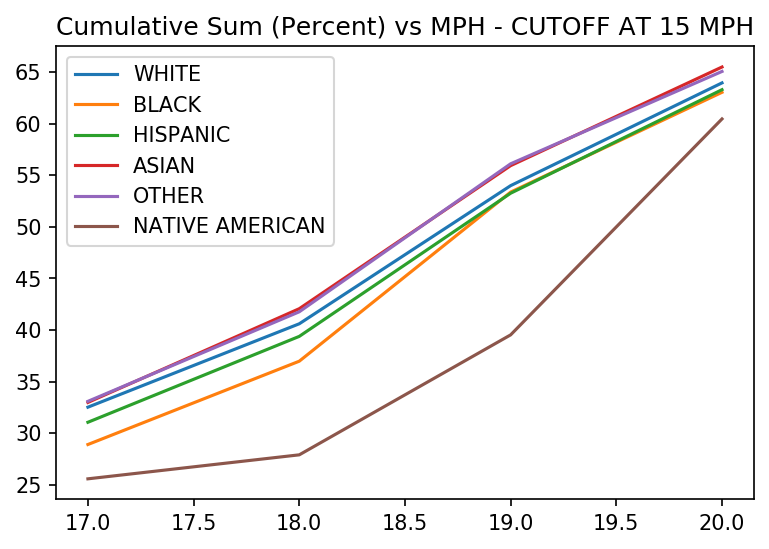

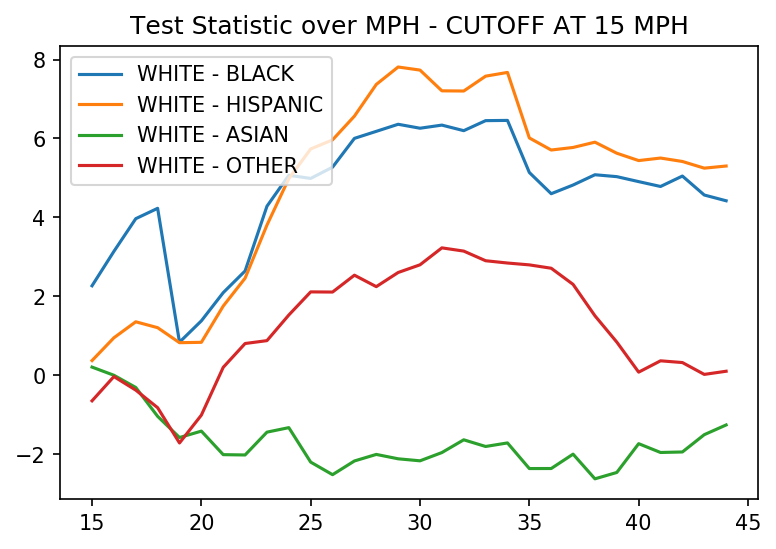

In [80]:
investigate_conditional_cutoff(15)

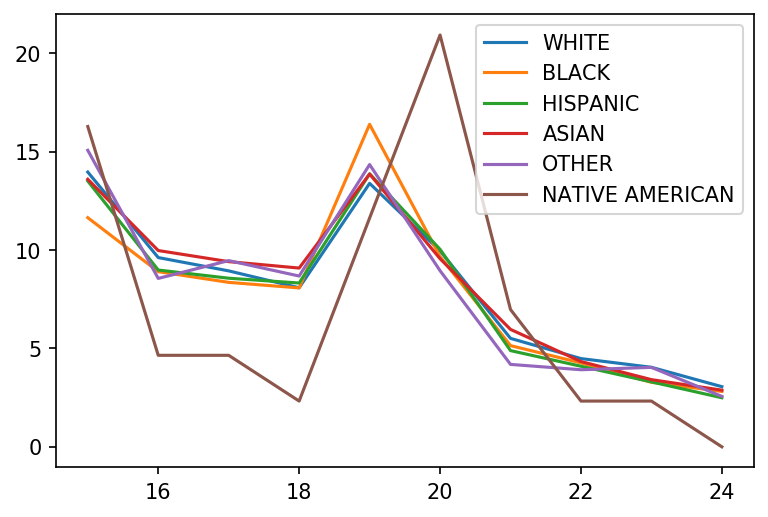

In [96]:
# generate_raw_count_df(df, 15, 100)[:25].plot()
create_speed_pct_PDF(df, 15, 100)[:10].plot()

## Manually compute z stat between white-black at 25 mph

Just confirming that the table is computed correctly

In [58]:
#manually 
speeed = 15

white = 85.736955 / 100
black = 83.587288 / 100

white_n = generate_raw_count_df(df, speeed, 100).cumsum()['WHITE'][25]
black_n = generate_raw_count_df(df, speeed, 100).cumsum()['BLACK'][25]

numerator_l = white - black
denominator_l = np.sqrt( (white * (1-white))/white_n + (black * (1-black))/black_n )

numerator_l / denominator_l

#so the z_statistics are correct

4.989024657890541

# Conclusion

(White, Black); and (White, Hispanic) appear to have different distributions